In [1]:
from google.colab import drive
drive.mount("/content/drive",force_remount=False)
print('done, mounted')

Mounted at /content/drive
done, mounted


In [2]:
cd /content/drive/My Drive/BC-MRI-AE/contrastive_vae

/content/drive/My Drive/BC-MRI-AE/contrastive_vae


In [3]:
#cd ../celeba_data/

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=2

import helper
import numpy as np
import matplotlib.pyplot as plt
from celeb_utils import get_synthetic_images, plot_sweeps_celeb, get_celeb_vae, filter_images_by_attribute, get_celeb_cvae, plot_contrastive_sweeps_celeb, show_images
#from celeb_utils import plot_clean_celebs_cvae, plot_contrastive_sweeps_celeb_big_latent
import pandas as pd

data_dir = '../celeba_data'
helper.download_extract('celeba', data_dir)

env: CUDA_VISIBLE_DEVICES=2
Found celeba Data


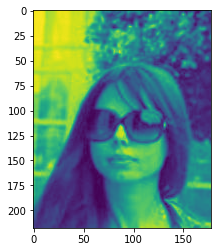

In [18]:
plt.imshow(cv2.imread(tg_ids[1], cv2.IMREAD_GRAYSCALE))

In [11]:
tg_ids[0:10]

['../celeba_data/img_align_celeba/000053.jpg',
 '../celeba_data/img_align_celeba/000093.jpg',
 '../celeba_data/img_align_celeba/000119.jpg',
 '../celeba_data/img_align_celeba/000144.jpg',
 '../celeba_data/img_align_celeba/000152.jpg',
 '../celeba_data/img_align_celeba/000154.jpg',
 '../celeba_data/img_align_celeba/000188.jpg',
 '../celeba_data/img_align_celeba/000189.jpg',
 '../celeba_data/img_align_celeba/000193.jpg',
 '../celeba_data/img_align_celeba/000202.jpg']

In [12]:
bg_ids[0:10]

['../celeba_data/img_align_celeba/000001.jpg',
 '../celeba_data/img_align_celeba/000002.jpg',
 '../celeba_data/img_align_celeba/000003.jpg',
 '../celeba_data/img_align_celeba/000004.jpg',
 '../celeba_data/img_align_celeba/000005.jpg',
 '../celeba_data/img_align_celeba/000006.jpg',
 '../celeba_data/img_align_celeba/000007.jpg',
 '../celeba_data/img_align_celeba/000008.jpg',
 '../celeba_data/img_align_celeba/000009.jpg',
 '../celeba_data/img_align_celeba/000010.jpg']

In [5]:
attr = 'Eyeglasses' ; reverse = False ; ratio = 0 ; latent_dim=2 ; latent_dim_s=6 ; width=28 ; height=28
tg_ids = filter_images_by_attribute(data_dir=data_dir, attr=attr, present=not(reverse))
bg_ids = filter_images_by_attribute(data_dir=data_dir, attr=attr, present=reverse)

show_n_images = 16
celeb_images = helper.get_batch(tg_ids[:show_n_images], width, height, 'RGB')

celeb_images

OSError: ignored

In [36]:
celeb_images.shape

(16, 28, 28, 3)

In [29]:
encoder, decoder, vae = get_celeb_vae(input_shape=(width, height, 3), latent_dim=2)

In [35]:
i = 0; batch_size = 16
batch_files = np.take(tg_ids, range(batch_size*i,batch_size*(i+1)), mode='wrap')
celeb_images = helper.get_batch(batch_files, width, height, 'RGB')
celeb_images /= 255
vae.train_on_batch(celeb_images)

44.61528015136719

In [ ]:
#tg_ids = filter_images_by_attribute(data_dir=data_dir, attr=attr, present=not(reverse))
#bg_ids = filter_images_by_attribute(data_dir=data_dir, attr=attr, present=reverse)

# Contrastive VAE with Disentangling

In [5]:
import random

def standard_and_contrastive_analysis(attr = 'Eyeglasses', reverse = False, ratio = 0, 
                                      latent_dim=2, latent_dim_s=6, width=28, height=28):
    random.seed(0)

    tg_ids = filter_images_by_attribute(data_dir=data_dir, attr=attr, present=not(reverse))
    bg_ids = filter_images_by_attribute(data_dir=data_dir, attr=attr, present=reverse)
    if len(tg_ids)*ratio > len(bg_ids):
        tg_ids = tg_ids[:int(len(bg_ids)/ratio)]
        tg_ids.extend(bg_ids) 
        random.shuffle(tg_ids)
    else:
        tg_ids.extend(bg_ids[:int(ratio*len(tg_ids))]) 
        random.shuffle(tg_ids)

    show_n_images = 16
    celeb_images = helper.get_batch(tg_ids[:show_n_images], width, height, 'RGB')
    plt.figure()
    plt.imshow(helper.images_square_grid(celeb_images, 'RGB'))

    show_n_images = 16
    celeb_images = helper.get_batch(bg_ids[:show_n_images], width, height, 'RGB')
    plt.figure()
    plt.imshow(helper.images_square_grid(celeb_images, 'RGB'))

    batch_size = 64
    
    encoder, decoder, vae = get_celeb_vae(input_shape=(width, height, 3), latent_dim=latent_dim, kernel_size=3)

    for i in range(1000):
        batch_files = np.take(tg_ids, range(batch_size*i,batch_size*(i+1)), mode='wrap')
        celeb_images = helper.get_batch(batch_files, width, height, 'RGB')
        celeb_images /= 255
        vae.train_on_batch(celeb_images)

        if i%25==0:
            print(i, end=' ')

    plot_sweeps_celeb(decoder, input_shape=(width, height, 3), latent_dim=latent_dim )

    cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = get_celeb_cvae(input_shape=(width, height, 3), kernel_size=5, 
        latent_dim=latent_dim, latent_dim_s=latent_dim_s, bias=True, disentangle=True, gamma=1)

    for i in range(1000):
        tg_files = np.take(tg_ids, range(batch_size*i,batch_size*(i+1)), mode='wrap')
        bg_files = np.take(bg_ids, range(batch_size*i,batch_size*(i+1)), mode='wrap')

        tg_images = helper.get_batch(tg_files, width, height, 'RGB')/255
        bg_images = helper.get_batch(bg_files, width, height, 'RGB')/255 
        cvae.train_on_batch([tg_images, bg_images])

        if i%25==0:
            print(i, end=' ')

    plot_contrastive_sweeps_celeb_big_latent(cvae_decoder, latent_dim_z=latent_dim, latent_dim_s=latent_dim_s, input_shape=(width, height, 3))
    plot_clean_celebs_cvae(cvae, z_encoder, s_encoder, cvae_decoder, tg_images, bg_images, plot=True, input_shape=(width, height, 3))

    cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = get_celeb_cvae(input_shape=(width, height, 3), kernel_size=5,
        latent_dim=latent_dim, latent_dim_s=latent_dim_s, bias=False, disentangle=True, gamma=1)

    for i in range(1000):
        tg_files = np.take(tg_ids, range(batch_size*i,batch_size*(i+1)), mode='wrap')
        bg_files = np.take(bg_ids, range(batch_size*i,batch_size*(i+1)), mode='wrap')

        tg_images = helper.get_batch(tg_files, width, height, 'RGB')/255
        bg_images = helper.get_batch(bg_files, width, height, 'RGB')/255 
        cvae.train_on_batch([tg_images, bg_images])

        if i%25==0:
            print(i, end=' ')

    plot_contrastive_sweeps_celeb_big_latent(cvae_decoder, latent_dim_z=latent_dim, latent_dim_s=latent_dim_s, input_shape=(width, height, 3))
    plot_clean_celebs_cvae(cvae, z_encoder, s_encoder, cvae_decoder, tg_images, bg_images, plot=True, input_shape=(width, height, 3))

In [6]:
latent_dim = 2
latent_dim_s = 6

standard_and_contrastive_analysis(latent_dim=latent_dim, latent_dim_s=latent_dim_s, width=64, height=64)

OSError: ignored

In [ ]:
latent_dim = 2
latent_dim_s = 4

standard_and_contrastive_analysis('Wearing_Hat', latent_dim=latent_dim, latent_dim_s=latent_dim_s, width=64, height=64)